## MLP(Multilayer Perceptron)

In [1]:
import mxnet as mx
import numpy as np

In [2]:
def get_symbol_mlp(num_hiddens):
    '''
    get_symbol_mlp:    a function to create a Multilayer Perceptron symbol by mxnet.
    
    params:
    -------
    num_hidden:    array, the number of hidden units
    
    returns:
    --------
    mlp:    a mxnet symbol
    '''
    data = mx.sym.Variable('data')
    data = mx.sym.Flatten(data = data)
    for num in range(len(num_hiddens) - 1):
        fc = mx.sym.FullyConnected(data=data, num_hidden=num_hiddens[num], name='fc'+str(num+1))
        data = mx.sym.Activation(data=fc, act_type='tanh', name='relu'+str(num+1))
    fc_softmax = mx.sym.FullyConnected(data=data, num_hidden=num_hiddens[-1], name='fc'+str(len(num_hiddens)) )
    mlp = mx.sym.SoftmaxOutput(data = fc_softmax, name='softmax')
    return mlp

In [3]:
# get mnist hand written data
mnist = mx.test_utils.get_mnist()

# Parepare
batch_size = 128
train_iter = mx.io.NDArrayIter(data=mnist['train_data'], 
                               label=mnist['train_label'], 
                               batch_size=batch_size, 
                               shuffle=True)

eval_iter = mx.io.NDArrayIter(data=mnist['test_data'], 
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)

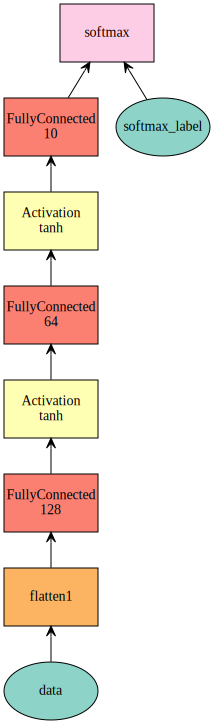

In [5]:
num_hiddens = [128, 64, 10]
mlp = get_symbol_mlp(num_hiddens=num_hiddens)
mx.viz.plot_network(mlp)

In [7]:
# Train
import logging
logging.getLogger().setLevel(logging.DEBUG)
# Create a trainable model on GPU
mlp_model = mx.mod.Module(symbol=mlp, context=mx.gpu())
mlp_model.fit(train_data=train_iter, 
              eval_data=eval_iter,
              force_init = True,
              optimizer='sgd', 
              optimizer_params={'learning_rate':0.1}, 
              eval_metric='acc', 
              batch_end_callback=mx.callback.Speedometer(batch_size, 128), 
              num_epoch=10)

INFO:root:Epoch[0] Batch [128]	Speed: 100632.14 samples/sec	accuracy=0.109314
INFO:root:Epoch[0] Batch [256]	Speed: 124402.34 samples/sec	accuracy=0.112793
INFO:root:Epoch[0] Batch [384]	Speed: 175708.65 samples/sec	accuracy=0.212036
INFO:root:Epoch[0] Train-accuracy=0.406064
INFO:root:Epoch[0] Time cost=0.464
INFO:root:Epoch[0] Validation-accuracy=0.471025
INFO:root:Epoch[1] Batch [128]	Speed: 164894.16 samples/sec	accuracy=0.608043
INFO:root:Epoch[1] Batch [256]	Speed: 138100.18 samples/sec	accuracy=0.772888
INFO:root:Epoch[1] Batch [384]	Speed: 155712.43 samples/sec	accuracy=0.835449
INFO:root:Epoch[1] Train-accuracy=0.848400
INFO:root:Epoch[1] Time cost=0.396
INFO:root:Epoch[1] Validation-accuracy=0.856705
INFO:root:Epoch[2] Batch [128]	Speed: 174702.69 samples/sec	accuracy=0.867248
INFO:root:Epoch[2] Batch [256]	Speed: 163252.43 samples/sec	accuracy=0.882568
INFO:root:Epoch[2] Batch [384]	Speed: 173075.99 samples/sec	accuracy=0.890625
INFO:root:Epoch[2] Train-accuracy=0.894903
INF

In [10]:
# Test
test_iter = mx.io.NDArrayIter(data=mnist['test_data'], 
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)
acc = mx.metric.Accuracy()
mlp_model.score(eval_data=test_iter, eval_metric=acc, reset=True)
print(acc)

EvalMetric: {'accuracy': 0.964003164556962}


In [120]:
help(mx.mod.Module.fit)

Help on function fit in module mxnet.module.base_module:

fit(self, train_data, eval_data=None, eval_metric='acc', epoch_end_callback=None, batch_end_callback=None, kvstore='local', optimizer='sgd', optimizer_params=(('learning_rate', 0.01),), eval_end_callback=None, eval_batch_end_callback=None, initializer=<mxnet.initializer.Uniform object at 0x7ff90a165240>, arg_params=None, aux_params=None, allow_missing=False, force_rebind=False, force_init=False, begin_epoch=0, num_epoch=None, validation_metric=None, monitor=None)
    Trains the module parameters.
    
    Checkout `Module Tutorial <http://mxnet.io/tutorials/basic/module.html>`_ to see
    a end-to-end use-case.
    
    Parameters
    ----------
    train_data : DataIter
        Train DataIter.
    eval_data : DataIter
        If not ``None``, will be used as validation set and the performance
        after each epoch will be evaluated.
    eval_metric : str or EvalMetric
        Defaults to 'accuracy'. The performance measure u

## Lenet

In [1]:
import mxnet as mx
import numpy as np

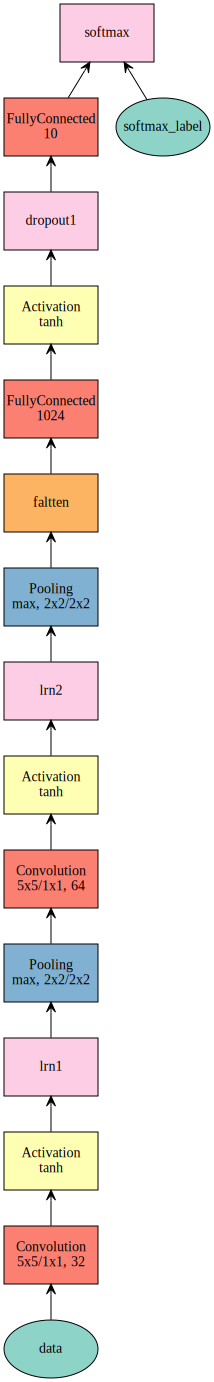

In [28]:
def get_symbol_lenet(num_classes):
    '''
    get_symbol_lenet:    a function to create a Lenet symbol by mxnet
    
    returns:
    --------
    
    '''
    input_data = mx.sym.Variable(name='data')
    
    # stage1
    conv1 = mx.sym.Convolution(data=input_data, kernel=(5, 5), stride=(1,1), num_filter=32,pad=(2,2), name='conv1')
    relu1 = mx.sym.Activation(data=conv1, act_type='tanh', name='relu1')
    lrn1 = mx.sym.LRN(data=relu1, alpha=0.001, beta=0.75, knorm=2, nsize=5, name='lrn1')
    pool1 = mx.sym.Pooling(data=lrn1, kernel=(2,2), stride=(2,2), pool_type='max', name='pool1')
    
    # stage2
    conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), stride=(1,1), num_filter=64,pad=(2,2), name='conv2')
    relu2 = mx.sym.Activation(data=conv2, act_type='tanh', name='relu2')
    lrn2 = mx.sym.LRN(data=relu2, alpha=0.0001, beta=0.75, knorm=2, nsize=5, name='lrn2')
    pool2 = mx.sym.Pooling(data=lrn2, kernel=(2,2), stride=(2,2), pool_type='max', name='pool2')
    
    # stage3
    flatten = mx.sym.Flatten(data=pool2, name='faltten')
    fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=1024, name='fc1')
    relu3 = mx.sym.Activation(data=fc1, act_type='tanh', name='relu3')
    dropout1 = mx.sym.Dropout(data=relu3, p=0.5, name='dropout1')
    
    # stage4 加了这一层全连接层之后，网络没有学习能力
    #fc2 = mx.sym.FullyConnected(data=relu3, num_hidden=256, name='fc2')
    #relu4 = mx.sym.Activation(data=fc2, act_type='relu', name='relu4')
    # dropout2 = mx.sym.Dropout(data=relu4, p=0.7, name='dropout2')
    
    # stage5
    fc3 = mx.sym.FullyConnected( data=dropout1, num_hidden=num_classes, name='fc3')
    lenet = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
    
    return lenet

lenet = get_symbol_lenet(10)
mx.viz.plot_network(lenet)

In [42]:
# get mnist hand written data
mnist = mx.test_utils.get_mnist()

# Parepare
batch_size = 128
train_iter = mx.io.NDArrayIter(data=mnist['train_data'], 
                               label=mnist['train_label'], 
                               batch_size=batch_size, 
                               shuffle=True)

eval_iter = mx.io.NDArrayIter(data=mnist['test_data'], 
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)

INFO:root:train-labels-idx1-ubyte.gz exists, skip to downloada
INFO:root:train-images-idx3-ubyte.gz exists, skip to downloada
INFO:root:t10k-labels-idx1-ubyte.gz exists, skip to downloada
INFO:root:t10k-images-idx3-ubyte.gz exists, skip to downloada


In [43]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
# create a trainable module on GPU

model_prefix = 'lenet_checkpoint/mx_lenet'
checkpoint = mx.callback.do_checkpoint(model_prefix)

lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
lenet_model.fit(train_data=train_iter,
              eval_data=eval_iter,
              optimizer='sgd',
              optimizer_params={'learning_rate':0.1},
              eval_metric='acc',
              batch_end_callback=mx.callback.Speedometer(batch_size, 128),
              num_epoch=20,
              epoch_end_callback=checkpoint)

INFO:root:Epoch[0] Batch [128]	Speed: 32284.28 samples/sec	accuracy=0.113675
INFO:root:Epoch[0] Batch [256]	Speed: 34534.83 samples/sec	accuracy=0.109985
INFO:root:Epoch[0] Batch [384]	Speed: 34258.81 samples/sec	accuracy=0.112122
INFO:root:Epoch[0] Train-accuracy=0.110212
INFO:root:Epoch[0] Time cost=1.808
INFO:root:Saved checkpoint to "lenet_checkpoint/mx_lenet-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.113726
INFO:root:Epoch[1] Batch [128]	Speed: 34147.99 samples/sec	accuracy=0.116279
INFO:root:Epoch[1] Batch [256]	Speed: 34695.63 samples/sec	accuracy=0.109985
INFO:root:Epoch[1] Batch [384]	Speed: 34554.17 samples/sec	accuracy=0.112122
INFO:root:Epoch[1] Train-accuracy=0.168062
INFO:root:Epoch[1] Time cost=1.769
INFO:root:Saved checkpoint to "lenet_checkpoint/mx_lenet-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.174347
INFO:root:Epoch[2] Batch [128]	Speed: 34368.78 samples/sec	accuracy=0.548147
INFO:root:Epoch[2] Batch [256]	Speed: 33955.78 samples/sec	accuracy=0

INFO:root:Epoch[19] Batch [256]	Speed: 34377.63 samples/sec	accuracy=0.989624
INFO:root:Epoch[19] Batch [384]	Speed: 34711.87 samples/sec	accuracy=0.991028
INFO:root:Epoch[19] Train-accuracy=0.991071
INFO:root:Epoch[19] Time cost=1.746
INFO:root:Saved checkpoint to "lenet_checkpoint/mx_lenet-0020.params"
INFO:root:Epoch[19] Validation-accuracy=0.987935


In [49]:
# test
test_iter = mx.io.NDArrayIter(data=mnist['test_data'], 
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)

acc = mx.metric.Accuracy()
lenet_model.score(test_iter, eval_metric=acc)
print(acc)

EvalMetric: {'accuracy': 0.98793512658227844}


## Alexnet

In [89]:
import mxnet as mx

In [ ]:
def get_symbol_alexnet(num_classes):
    input_data = mx.sym.Variable('data')
    
    # stage 1
    conv1 = mx.sym.Convolution(data=input_data, kernel=(5,5), stride=(1,), num_filter=96, name='conv1')
    relu1 = mx.sym.Activation(data=conv1, act_type='relu', name='relu1')
    lrn1 = mx.sym.LRN(data=relu1, alpha=0.0001, beta=0.75, knorm=2, nsize=5, name='lrn1')
    pool1 = mx.sym.Pooling(data=lrn1, pool_type='max', kernel=(3,3), stride=(2,2))
    
    # stage 2
    conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), stride=(1,1), pad=(2,2), num_filter=256, name='conv2')
    relu2 = mx.sym.Activation(data=conv2, act_type='relu', name='relu2')
    lrn2 = mx.sym.LRN(data=relu2, alpha=0.0001, beta=0.75, knorm=2, nsize=5, name='lrn2')
    pool2 = mx.sym.Pooling(data=lrn2, kernel=(3,3), stride=(2,2), pool_type='max', name='pool2')
    
    # stage 3
    conv3 = mx.sym.Convolution(data=pool2, kernel=(3,3), stride=(1,1), pad=(1,1), num_filter=384, name='conv3')
    relu3 = mx.sym.Activation(data=conv3, act_type='relu', name='relu3')
    conv4 = mx.sym.Convolution(data=relu3, kernel=(3,3), stride=(1,1), pad=(1,1), num_filter=384, name='conv4')
    relu4 = mx.sym.Activation(data=conv4, act_type='relu', name='relu4')
    conv5 = mx.sym.Convolution(data=relu4, kernel=(3,3), stride=(1,1), pad=(1,1), num_filter=256, name='conv5')
    relu5 = mx.sym.Activation(data=conv5, act_type='relu', name='relu5')
    pool3 = mx.sym.Pooling(data=relu5, kernel=(3,3), stride=(2,2), pool_type='max', name='pool3')
    
    # stage 4
    flatten = mx.sym.Flatten(data=pool3)
    fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=4096, name='fc1')
    relu6 = mx.sym.Activation(data=fc1, act_type='relu', name='relu6')
    dropout1 = mx.sym.Dropout(data=relu6, p=0.5)
    
    # stage 5
    fc2 = mx.sym.FullyConnected(data=dropout1, num_hidden=4096, name='fc2')
    relu7 = mx.sym.Activation(data=fc2, act_type='relu')
    dropout2 = mx.sym.Dropout(data=relu7, p=0.5)
    
    # stage 6
    fc3 = mx.sym.FullyConnected(data=dropout2, num_hidden=num_classes, name='fc3')
    alexnet = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
    return alexnet

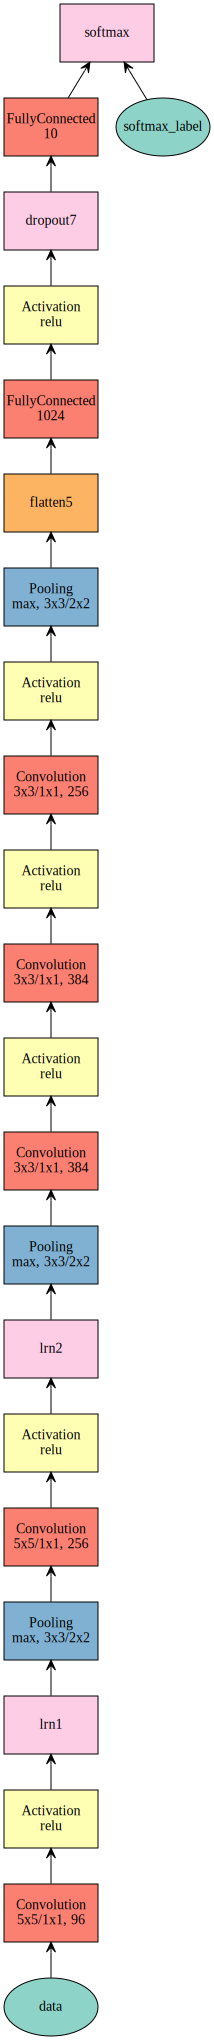

In [117]:
alexnet = get_symbol_alexnet(10)
mx.viz.plot_network(alexnet)

在手写数字上不会有很好的结果

In [ ]:
batch_size = 128
train_iter = mx.io.NDArrayIter(data=mnist['train_data'],
                               label=mnist['train_label'],
                               batch_size=batch_size,
                               shuffle=True)

eval_iter = mx.io.NDArrayIter(data=mnist['test_data'],
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)

import logging
logging.getLogger().setLevel(logging.DEBUG)

alexnet_model = mx.mod.Module(symbol=alexnet, context=mx.gpu())

alexnet_model.fit(train_data=train_iter, 
                  eval_data=eval_iter, 
                  optimizer='sgd',
                  optimizer_params={'learning_rate':0.1},
                  eval_metric='acc', 
                  num_epoch=20)